In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('./train_bl.csv')
train.info()
RANDOM_SEED = 42

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB



client_id	идентификатор клиента

education	уровень образования

sex	пол заёмщика

age	возраст заёмщика

car	флаг наличия автомобиля

car_type	флаг автомобиля-иномарки

decline_app_cnt	количество отказанных прошлых заявок

good_work	флаг наличия «хорошей» работы

bki_request_cnt	количество запросов в БКИ

home_address	категоризатор домашнего адреса

work_address	категоризатор рабочего адреса

income	доход заёмщика

foreign_passport	наличие загранпаспорта

default	наличие дефолта


In [3]:
train.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0


In [4]:
train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

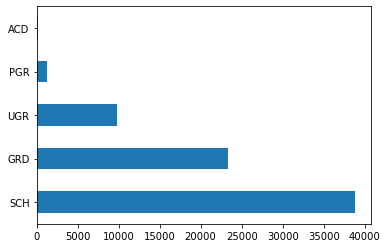

In [5]:
train.education.value_counts().plot.barh()

In [6]:
num_cols = ['age','decline_app_cnt', 'bki_request_cnt', 'income']

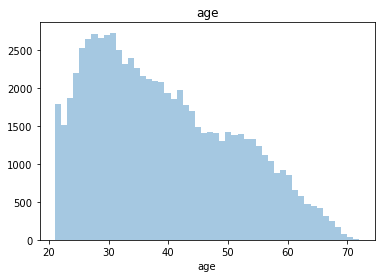

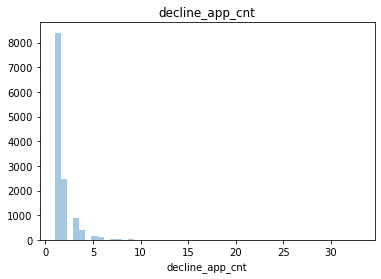

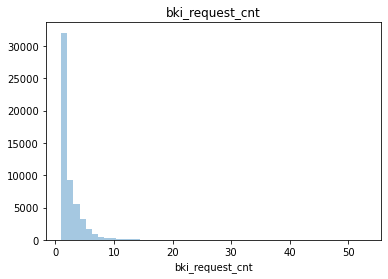

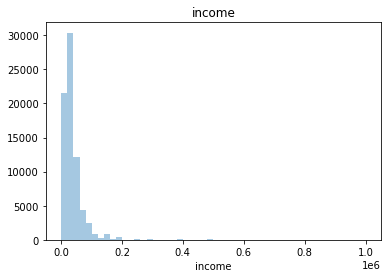

In [7]:
for i in num_cols:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [8]:
train[num_cols].corr()

,age,decline_app_cnt,bki_request_cnt,income
age,1.000000,-0.111175,0.046265,-0.018900
decline_app_cnt,-0.111175,1.000000,0.155894,-0.021687
bki_request_cnt,0.046265,0.155894,1.000000,0.082983
income,-0.018900,-0.021687,0.082983,1.000000


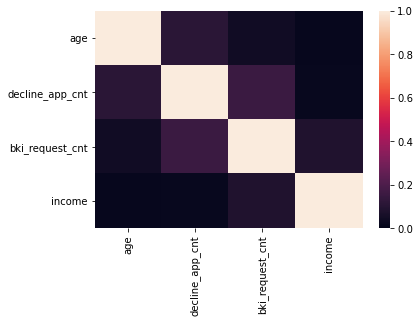

In [9]:
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1)

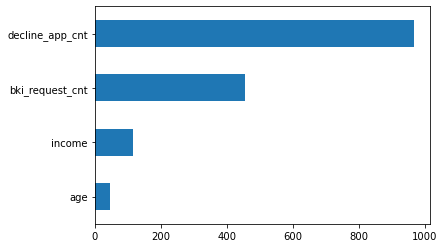

In [10]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [11]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(train['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [12]:
train.sample(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
60658,60011,GRD,M,54,Y,Y,0,1,2,2,3,18000,N,0
5974,67176,GRD,F,30,N,N,0,0,2,1,1,25000,N,1
10094,109513,SCH,F,26,N,N,0,0,3,2,3,40000,N,0


In [13]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [14]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
# убедимся в преобразовании    
train.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,SCH,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,SCH,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,SCH,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,GRD,1,48,0,0,0,1,1,2,3,30000,1,0


In [15]:
cat_cols = ['education', 'home_address', 'work_address']

In [16]:
train['education'] = train['education'].fillna(train['education'].describe().top)
train['education'].value_counts()

SCH    39167
GRD    23365
UGR     9816
PGR     1257
ACD      194
Name: education, dtype: int64

In [17]:
edu_label_encoder = LabelEncoder()
train['education'] = edu_label_encoder.fit_transform(train['education'])
train['education'] 

0        3
1        3
2        3
3        3
4        1
        ..
73794    1
73795    3
73796    3
73797    3
73798    1
Name: education, Length: 73799, dtype: int32

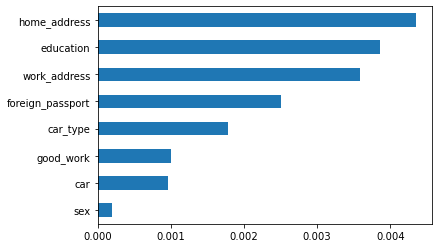

In [18]:
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [19]:
train.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,3,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,3,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,3,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,3,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,1,1,48,0,0,0,1,1,2,3,30000,1,0


In [20]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)

In [21]:
len(X_cat[0])

11

In [22]:
train[cat_cols].values

array([[3, 1, 2],
       [3, 2, 3],
       [3, 1, 2],
       ...,
       [3, 2, 3],
       [3, 1, 3],
       [1, 2, 3]], dtype=int64)

In [23]:
X_num = StandardScaler().fit_transform(train[num_cols].values)
X_num

array([[ 1.97211528e+00, -3.42857656e-01, -4.44188844e-01,
        -5.00363267e-01],
       [ 1.71170539e+00, -3.42857656e-01,  4.43888001e-01,
        -4.78702309e-01],
       [-1.23960668e+00,  2.14387966e+00, -4.44188844e-01,
        -2.40431770e-01],
       ...,
       [-7.18786904e-01, -3.42857656e-01,  8.87926424e-01,
         8.44826013e-02],
       [-8.92393496e-01, -3.42857656e-01,  4.43888001e-01,
        -6.08668058e-01],
       [-4.58377015e-01, -3.42857656e-01, -1.50421558e-04,
        -3.48736561e-01]])

In [24]:
X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

In [25]:
pd.DataFrame(X).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       73799 non-null  float64
 1   1       73799 non-null  float64
 2   2       73799 non-null  float64
 3   3       73799 non-null  float64
 4   4       73799 non-null  float64
 5   5       73799 non-null  float64
 6   6       73799 non-null  float64
 7   7       73799 non-null  float64
 8   8       73799 non-null  float64
 9   9       73799 non-null  float64
 10  10      73799 non-null  float64
 11  11      73799 non-null  float64
 12  12      73799 non-null  float64
 13  13      73799 non-null  float64
 14  14      73799 non-null  float64
 15  15      73799 non-null  float64
 16  16      73799 non-null  float64
 17  17      73799 non-null  float64
 18  18      73799 non-null  float64
 19  19      73799 non-null  float64
dtypes: float64(20)
memory usage: 11.3 MB


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


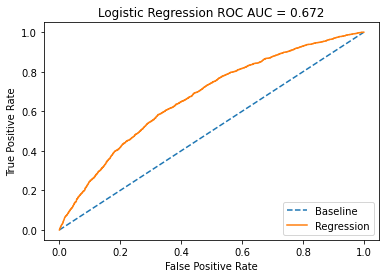

In [27]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [28]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=RANDOM_SEED)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)


	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l1'
	random_state: 42
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False


In [29]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, recall_score, f1_score
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

Accuracy: 0.6131
Precision: 0.1880
Recall: 0.6404
F1: 0.2907


In [30]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packa

Лучшее Penalty: l2
Лучшее C: 1.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=RANDOM_SEED)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

In [ ]:
train = pd.read_csv('./train_bl.csv')
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
train = train.drop('client_id', axis=1)
train['education'] = train.apply(lambda x: ('SCH' if x.income <=28000 else 'UGR')\
                             if pd.isna(x.education) else x.education , axis=1)
train['education'] = train['education'].apply(lambda x: x.replace("SCH", '0').replace("GRD", '1').replace('UGR', '2').replace("PGR", '3').replace("ACD", '4'))
label_encoder = LabelEncoder()
mapped_education = pd.Series(label_encoder.fit_transform(train['sex']))
print(dict(enumerate(label_encoder.classes_)))
label_encoder = LabelEncoder()
for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
# убедимся в преобразовании
train.head()
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(train[num_cols].values)
# Объединяем
X = np.hstack([X_num, train[bin_cols].values, X_cat])
y = train['default'].values
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)
# Реализовать функцию sigmoid
def sigmoid(X, theta):
    return 1. / (1. + np.exp(-X.dot(theta)))
# Реализовать функцию, вычисляющую градиент бинарной кросс-энтропии
def calc_binary_cross_entropy_grad(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(sigmoid(X, theta) - y)
    return grad
def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad
def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    return theta
# Оптимизировать параметр линейной регрессии theta на всех данных
#theta = optimize(X_train, y_train, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)
#model = LogisticRegression(max_iter=1000)
#model.fit(X_train,y_train)
#y_pred = model.predict(X_valid)
from sklearn.model_selection import GridSearchCV
# Добавим типы регуляризации
penalty = ['l1', 'l2']
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)
# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_train, y_train)
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)
# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

In [ ]:
show_model_result(best_model, X_valid, y_valid)